# Random Forest model for Ames

# Contents

[RandomForest](#RandomForest)

[Feature Importances](#Feature-Importances)

[SHAP Values](#SHAP-Values)

[Summary](#Summary)

[Resources](#Resources)

In [53]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import ensemble

## Import raw data for reference

In [8]:
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


In [10]:
ames = pd.read_pickle('ames_clean.pkl')
ames.head(2)

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,126000,30,RL,68.0,7890,Pave,None,Reg,Lvl,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,139500,120,RL,42.0,4235,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,2,2009,WD,Normal


In [12]:
# remove target from dataframe
y = ames['SalePrice']
ames.drop(columns=['SalePrice'], axis=1, inplace=True)
ames.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,68.0,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal


## Import cleaned data for modeling

**Summary of previous data cleaning:**

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'

**ames_clean.pkl** include these changes.

In [15]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [17]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [19]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
# extract ordinal_features_list from ordinal_order below
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


Ran into an error with datatypes during encoding. OverallQual and OverallCond, while reclassified as object types, are still int types. Convert OverallQual, OverallCond, YrSold, and MoSold from int type to str type for ordinal encoding.

In [22]:
str_OverallQual = ames['OverallQual'].astype(str)
str_OverallCond = ames['OverallCond'].astype(str)
print(type(ames['OverallQual'][0]))
print(type(str_OverallQual[0]))

<class 'int'>
<class 'str'>


In [24]:
ames['OverallCond'] = ames['OverallCond'].astype(str)
ames['OverallQual'] = ames['OverallQual'].astype(str)
ames['MoSold'] = ames['MoSold'].astype(str)
ames['YrSold'] = ames['YrSold'].astype(str)

In [26]:
# define ordering for ordinal features
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],  # General shape of property
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Type of utilities available
    'LandSlope': ['Sev', 'Mod', 'Gtl'],  # Slope of property
    # 
    'OverallQual': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'OverallCond': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    #
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # General condition of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of basement finished area
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of second basement finished area
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality and condition
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],  # Interior finish of the garage
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'PavedDrive': ['N', 'P', 'Y'],  # Paved driveway
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],  # Fence quality
    'MoSold': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    'YrSold': ['2006', '2007', '2008', '2009', '2010']
    # 'MoSold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  
    # 'YrSold': [2006, 2007, 2008, 2009, 2010]
}

In [28]:
# get list of ordinal features that syncs with ordinal dictionary 
ordinal_features_list = list(ordinal_order.keys())
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [30]:
# stack features for processing: numerical + nominal + ordinal
X = ames[numerical_features_list].join(ames[nominal_features_list])
X = X.join(ames[ordinal_features_list])
X.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


# RandomForest

[Contents](#Contents)

**Method:**

1. Build pipeline:
- numerical features - no scaling; passthrough
- nominal features: one-hot encode
- ordinal features: ordinal encode

2. Get a base model: evaluate model on full dataset and default parameters using cross validation

3. Tune hyperparameters with GridSearchCV 
- fit grid object to full dataset and retrieve cv score for full dataset (X and y). This is the score that will be used to evaluate the model and compare to other models. 
- fit grid object to train and test data to examine train-test gap for overfitting.

4. Choose best optimized model (based on highest cv score)

# 1. Build Pipeline

In [327]:
# define transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('num', 'passthrough')
])

# define one-hot transformer for nominal features
nominal_transformer = Pipeline(steps=[
    ('nominal', OneHotEncoder(handle_unknown='ignore'))
])

# define categories for ordinal encoding
ord_categories = [ordinal_order[feature] for feature in ordinal_features_list]

# define ordinal transformer
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ord_categories))
])

# set up preprocessor for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_list),
        ('nominal', nominal_transformer, nominal_features_list),
        ('ordinal', ordinal_transformer, ordinal_features_list)
])

# define model pipeline with preprocessor and regressor on default params
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regressor', ensemble.RandomForestRegressor(random_state=42))
          ]
)

In [329]:
# fit model
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   'passthrough')]),
                                                  ['GrLivArea', 'LotFrontage',
                                                   'LotArea', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'Kitch...
                                                  ['Electrical', 'LotShape',
                                                   'Utilities', 'LandSlope',
                                                   'OverallQual', 'OverallCond',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive',
                                                   'PoolQC', 'Fence', 'MoSold',
                                                   'YrSold'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

### Double check encoding

In [332]:
X_transformed = pipeline.named_steps['preprocessor'].transform(X)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
transformed_df = pd.DataFrame(X_transformed, columns=feature_names, index=X.index)
transformed_df.head()

,num__GrLivArea,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,...,ordinal__Functional,ordinal__FireplaceQu,ordinal__GarageFinish,ordinal__GarageQual,ordinal__GarageCond,ordinal__PavedDrive,ordinal__PoolQC,ordinal__Fence,ordinal__MoSold,ordinal__YrSold
0,856.0,68.0,7890.0,1939.0,1950.0,0.0,238.0,0.0,618.0,856.0,...,7.0,4.0,1.0,3.0,3.0,2.0,0.0,0.0,2.0,4.0
1,1049.0,42.0,4235.0,1984.0,1984.0,149.0,552.0,393.0,104.0,1049.0,...,7.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,1.0,3.0
2,1001.0,60.0,6060.0,1930.0,2007.0,0.0,737.0,0.0,100.0,837.0,...,7.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,10.0,1.0
3,1039.0,80.0,8146.0,1900.0,2003.0,0.0,0.0,0.0,405.0,405.0,...,7.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,4.0,3.0
4,1665.0,70.0,8400.0,2001.0,2001.0,0.0,643.0,0.0,167.0,810.0,...,7.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,10.0,3.0


In [336]:
X.head()

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009
2,1001,60.0,6060,1930,2007,0.0,737.0,0.0,100.0,837.0,...,Typ,None,Unf,TA,Po,N,None,None,11,2007
3,1039,80.0,8146,1900,2003,0.0,0.0,0.0,405.0,405.0,...,Typ,None,Unf,TA,TA,N,None,None,5,2009
4,1665,70.0,8400,2001,2001,0.0,643.0,0.0,167.0,810.0,...,Typ,None,Fin,TA,TA,Y,None,None,11,2009


Looks good.

# 2. Base Model
Evaluate  model on full dataset and default parameters using cross validation

In [175]:
scores = cross_val_score(pipeline, X, y)
mean_score_base_model = scores.mean()
print(f'cv scores:', scores)
print(f'mean-cv base model score:', round(mean_score_base_model, 4))

cv scores: [0.84132755 0.89806569 0.9044275  0.91593029 0.91595742]
mean-cv base model score: 0.8951


In [143]:
# create storage for tuning results
tuning_results = {}

# 3. Model Tuning
Tune model on train-test data using cross validation (via GridSearchCV)
- Evaluate model on cv score from best_score_ and best_estimator_
- Examine train_test gap for best_estimator
- Choose best optimized model (highest cv score)

In [177]:
# check for overfitting

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# refit the pipeline on train-test data
pipeline.fit(X_train, y_train)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
diff = train_score - test_score

print(f'base model mean cv score: {round(scores.mean(), 4)}')
print(f'base model train score:', round(train_score, 4))
print(f'base model test score:', round(test_score, 4))
print(f'base model train-test gap:', round(diff, 4))

tuning_results['Model _0'] = {
    'mean-cv on X and y': round(mean_score_base_model, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

base model mean cv score: 0.8951
base model train score: 0.9836
base model test score: 0.9088
base model train-test gap: 0.0749


In [145]:
# Tuning the random forest model
forest_params_1 = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]  
}

forest_grid_1 = GridSearchCV(
    pipeline, 
    forest_params_1, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
forest_grid_1.fit(X, y)
forest_best_model_1 = forest_grid_1.best_estimator_

# Evaluate model on full dataset, X and y
model_params = forest_grid_1.best_params_
full_cv = round(forest_grid_1.best_score_, 4)
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters: {forest_grid_1.best_params_}')
print(f'mean cv score on full dataset: {forest_grid_1.best_score_:.4f}')
print('-----------')

# check for overfitting on train-test data
forest_grid_1.fit(X_train, y_train)
best_train_model = forest_grid_1.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _1'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _1:
Evaluate model on full dataset:
model parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
mean cv score on full dataset: 0.8958
-----------
Check for overfitting on train-test data:
train score: 0.9746
test score: 0.905
train-test gap: 0.0696


In [149]:
# Tuning the random forest model
forest_params_2 = {
    'regressor__n_estimators': [300, 400],
    'regressor__max_depth': [30, 40],
    'regressor__min_samples_split': [7, 9],
    'regressor__min_samples_leaf': [3,4] 
}

forest_grid_2 = GridSearchCV(
    pipeline, 
    forest_params_2, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
forest_grid_2.fit(X, y)
forest_best_model_2 = forest_grid_2.best_estimator_

# Evaluate model on full dataset, X and y
model_params = forest_grid_2.best_params_
full_cv = round(forest_grid_2.best_score_, 4)

print('MODEL _2:')
print('Evaluate model on full dataset:')
print(f'model parameters: {forest_grid_2.best_params_}')
print(f'mean cv score on full dataset: {forest_grid_2.best_score_:.4f}')
print('-----------')
# check for overfitting on train-test data
forest_grid_2.fit(X_train, y_train)
best_train_model = forest_grid_2.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _2'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _2:
Evaluate model on full dataset:
model parameters: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 7, 'regressor__n_estimators': 400}
mean cv score on full dataset: 0.8938
-----------
Check for overfitting on train-test data:
train score: 0.9664
test score: 0.9025
train-test gap: 0.0639


In [151]:
# Tuning the random forest model
forest_params_3 = {
    'regressor__n_estimators': [500, 600],
    'regressor__max_depth': [23, 25, 27],
    'regressor__min_samples_split': [5, 6, 7],
    'regressor__min_samples_leaf': [2, 3] 
}

forest_grid_3 = GridSearchCV(
    pipeline, 
    forest_params_3, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
forest_grid_3.fit(X, y)
forest_best_model_3 = forest_grid_3.best_estimator_

# Evaluate model on full dataset, X and y
model_params = forest_grid_3.best_params_
full_cv = round(forest_grid_3.best_score_, 4)

print('MODEL _3:')
print('Evaluate model on full dataset:')
print(f'model parameters: {forest_grid_3.best_params_}')
print(f'mean cv score on full dataset: {forest_grid_3.best_score_:.4f}')
print('-----------')
# check for overfitting on train-test data
forest_grid_3.fit(X_train, y_train)
best_train_model = forest_grid_3.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _3'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _3:
Evaluate model on full dataset:
model parameters: {'regressor__max_depth': 25, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 600}
mean cv score on full dataset: 0.8959
-----------
Check for overfitting on train-test data:
train score: 0.9756
test score: 0.9057
train-test gap: 0.0698


In [155]:
# Tuning the random forest model
forest_params_4 = {
    'regressor__n_estimators': [600, 800],
    'regressor__max_depth': [24, 25, 26],
    'regressor__min_samples_split': [4, 5],
    'regressor__min_samples_leaf': [1, 2] 
}

forest_grid_4 = GridSearchCV(
    pipeline, 
    forest_params_4, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
forest_grid_4.fit(X, y)
forest_best_model_4 = forest_grid_4.best_estimator_
 
# Evaluate model on full dataset, X and y
model_params = forest_grid_4.best_params_
full_cv = round(forest_grid_4.best_score_, 4)

print('MODEL _4:')
print('Evaluate model on full dataset:')
print(f'model parameters: {forest_grid_4.best_params_}')
print(f'mean cv score on full dataset: {forest_grid_4.best_score_:.4f}')
print('-----------')
# check for overfitting on train-test data
forest_grid_4.fit(X_train, y_train)
best_train_model = forest_grid_4.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _4'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _4:
Evaluate model on full dataset:
model parameters: {'regressor__max_depth': 26, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 600}
mean cv score on full dataset: 0.8964
-----------
Check for overfitting on train-test data:
train score: 0.9756
test score: 0.9058
train-test gap: 0.0698


In [157]:
# Tuning the random forest model
forest_params_5 = {
    'regressor__n_estimators': [650, 700, 750],
    'regressor__max_depth': [26],
    'regressor__min_samples_split': [4],
    'regressor__min_samples_leaf': [2]  
}

forest_grid_5 = GridSearchCV(
    pipeline, 
    forest_params_5, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

# fit on all the data to get the overall score
forest_grid_5.fit(X, y)
forest_best_model_5 = forest_grid_5.best_estimator_

# Evaluate model on full dataset, X and y
model_params = forest_grid_5.best_params_
full_cv = round(forest_grid_5.best_score_, 4)

print('MODEL _5:')
print('Evaluate model on full dataset:')
print(f'model parameters: {forest_grid_5.best_params_}')
print(f'mean cv score on full dataset: {forest_grid_5.best_score_:.4f}')
print('-----------')
# check for overfitting on train-test data
forest_grid_5.fit(X_train, y_train)
best_train_model = forest_grid_5.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _5'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

MODEL _5:
Evaluate model on full dataset:
model parameters: {'regressor__max_depth': 26, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 700}
mean cv score on full dataset: 0.8966
-----------
Check for overfitting on train-test data:
train score: 0.977
test score: 0.9063
train-test gap: 0.0708


**Note:**

Assessing scores... mean-cv is the average cv score over 5 folds for the entire dataset. All the data is accounted for. The test score is evaluating performance on unseen data over one fold. All the test scores are close to the mean-cv scores, indicating stability within the model. Makes sense that the mean-cv would be a little lower than the test score. Would worry about model stability if test was quite a bit different than the mean-cv. 

In [712]:
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _5,0.8966,0.9770,0.9063,0.0708
Model _4,0.8964,0.9756,0.9058,0.0698
Model _3,0.8959,0.9756,0.9057,0.0698
Model _1,0.8958,0.9746,0.9050,0.0696
Model _0,0.8951,0.9836,0.9088,0.0749
Model _2,0.8938,0.9664,0.9025,0.0639


# 4. Best Model 
Choose best optimized model based on highest cv score fit to full dataset

In [348]:
forest_grid_5.best_params_

{'regressor__max_depth': 26,
 'regressor__min_samples_leaf': 2,
 'regressor__min_samples_split': 4,
 'regressor__n_estimators': 750}

# Feature Importances

[Contents](#Contents)

Evaluate feature importances on best tuned model. 

In [595]:
feature_importances = {}

pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regressor', ensemble.RandomForestRegressor(random_state=42,
                                                        max_depth = 26, 
                                                        min_samples_leaf = 2, 
                                                        min_samples_split = 4,
                                                        n_estimators = 750))
          ]
)
pipeline.fit(X, y) 
importances = pipeline.named_steps['regressor'].feature_importances_
feature_importances = importances     

In [351]:
#feature_importances

In [597]:
# get feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

In [599]:
# create dataframe
feature_importances_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importance'])
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:20]

,Importance
ordinal__OverallQual,0.555103
num__GrLivArea,0.141864
num__1stFlrSF,0.059101
num__TotalBsmtSF,0.040308
num__GarageArea,0.024944
num__BsmtFinSF1,0.024675
num__LotArea,0.013737
num__YearBuilt,0.009481
num__2ndFlrSF,0.007621
num__YearRemodAdd,0.007270


**Note:** This feature ranking will differ from the one below, because of the split data used to train the model for SHAP. 

# SHAP Values
[Contents](#Contents)

In [615]:
# define model pipeline with preprocessor and regressor on optimized params
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regressor', ensemble.RandomForestRegressor(random_state = 42,
                                                        max_depth = 26, 
                                                        min_samples_leaf = 2, #100 to double check nominal_SaleCondition_Partial
                                                        min_samples_split = 4,
                                                        n_estimators = 750))
          ]
)
# fit the final model for SHAP analysis
final_model = pipeline.fit(X_train, y_train)

In [442]:
final_model.score(X_train, y_train)

0.9770473454727678

In [444]:
final_model.score(X_test, y_test)

0.906269000320727

In [446]:
import shap

In [448]:
print(f'model baseline: $',round(y.mean(),2))

model baseline: $ 178059.62


### transform test data for SHAP

In [460]:
fitted_pre = final_model.named_steps['preprocessor']
fitted_pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num', 'passthrough')]),
                                 ['GrLivArea', 'LotFrontage', 'LotArea',
                                  'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                  'LowQualFinSF', 'BsmtFullBath',
                                  'BsmtHalfBath', 'FullBath', 'HalfBath',
                                  'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'Firepla...
                                                                             ['2006',
                                                                              '2007',
                                                                              '2008',
                                                                              '2009',
                                                                              '2010']]))]),
                                 ['Electrical', 'LotShape', 'Utilities',
                                  'LandSlope', 'OverallQual', 'OverallCond',
                                  'ExterQual', 'ExterCond', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                  'Functional', 'FireplaceQu', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive',
                                  'PoolQC', 'Fence', 'MoSold', 'YrSold'])])

In [494]:
# transform training data with the *fitted* preprocessor
X_train_t = fitted_pre.transform(X_train)
X_test_t = fitted_pre.transform(X_test)

In [532]:
# X_test_t

array([[1.0530e+03, 6.0000e+01, 8.2500e+03, ..., 0.0000e+00, 6.0000e+00,
        1.0000e+00],
       [1.1270e+03, 6.5000e+01, 6.5000e+03, ..., 0.0000e+00, 4.0000e+00,
        2.0000e+00],
       [1.1280e+03, 6.0000e+01, 7.5000e+03, ..., 0.0000e+00, 3.0000e+00,
        4.0000e+00],
       ...,
       [9.9000e+02, 4.3000e+01, 1.3568e+04, ..., 0.0000e+00, 6.0000e+00,
        0.0000e+00],
       [1.0080e+03, 6.5000e+01, 6.8600e+03, ..., 0.0000e+00, 1.1000e+01,
        1.0000e+00],
       [1.7820e+03, 1.2900e+02, 1.6870e+04, ..., 0.0000e+00, 3.0000e+00,
        3.0000e+00]])

In [540]:
# X_test.head()

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
953,1053,60.0,8250,1963,1963,0.0,288.0,0.0,765.0,1053.0,...,Typ,None,RFn,TA,TA,Y,None,None,7,2007
330,1127,65.0,6500,1976,1976,84.0,1033.0,0.0,94.0,1127.0,...,Typ,Po,Unf,TA,TA,Y,None,None,5,2008
670,1128,60.0,7500,1920,1950,0.0,0.0,0.0,698.0,698.0,...,Typ,None,RFn,TA,TA,Y,None,None,4,2010
302,1468,74.0,9612,2008,2009,72.0,0.0,0.0,1468.0,1468.0,...,Typ,Gd,Fin,TA,TA,Y,None,None,12,2009
436,1285,71.0,8197,1977,1977,148.0,0.0,0.0,660.0,660.0,...,Typ,TA,RFn,TA,TA,Y,None,MnPrv,4,2007


In [542]:
# # SHAP summary_plot likes dense arrays; OneHotEncoder often returns sparse
# import scipy.sparse as sp
# if sp.issparse(X_test_t):
#     X_test_t = X_test_t.toarray()

**Note:**
feature_perturbation="interventional": key optimization for one-hot encoded features.

Default behavior ("tree_path_dependent"):

- Treats each one-hot column independently
- Can give misleading results because it might show effects like "having both Category_A=1 AND Category_B=1" which is impossible

"interventional" behavior:

- Understands that one-hot encoded features are mutually exclusive
- When perturbing a categorical variable, it properly handles the constraint that only one category can be active
- More realistic feature interactions

Example:
- Default: Might consider unrealistic combinations like Red=1, Blue=1
- Interventional: Properly handles that if Red=1, then Blue=0 and Green=0

**note:** SHAP roadmap:
- final_model fit on transformed training data
- explainer <-- final model (rf)
- shap_values <-- transformed training data
- model_pred <-- transformed test data
- summary_plot <-- transformed test data

In [512]:
rf = final_model.named_steps['regressor']
import shap
# For tree models, TreeExplainer is fast and exact-ish
explainer = shap.TreeExplainer(rf, feature_perturbation="interventional")  # good with one-hot features
shap_values = explainer.shap_values(X_test_t)

/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


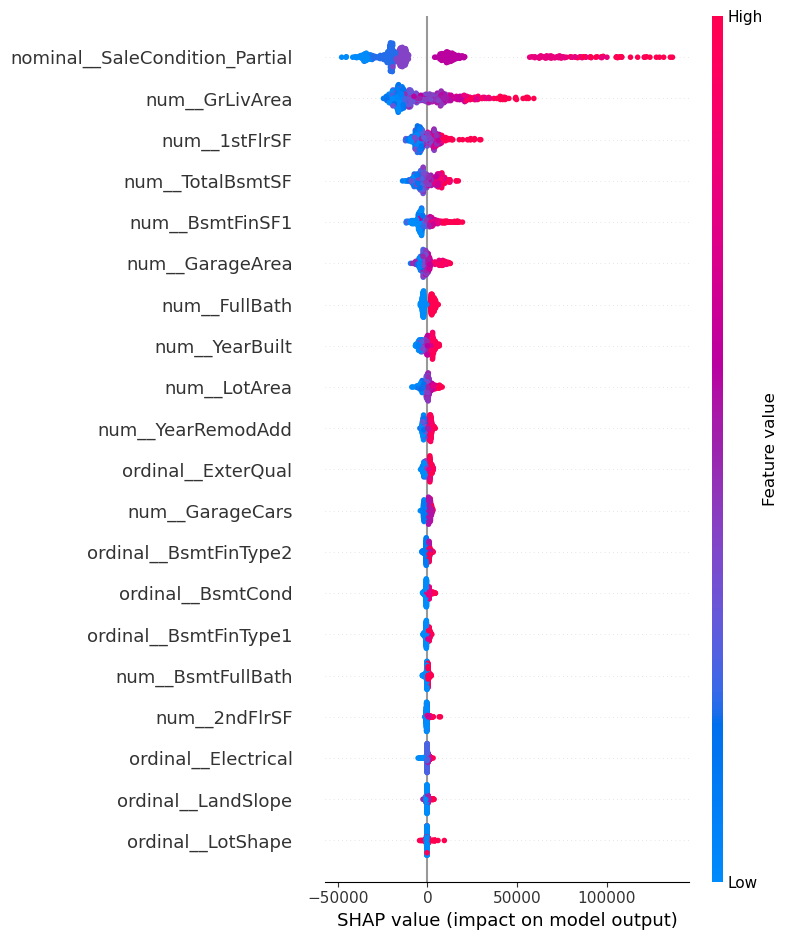

In [611]:
shap.summary_plot(shap_values, X_test_t, feature_names=feature_names)

In [516]:
explainer.expected_value[0]

177360.0836763566

In [518]:
print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# The base value (expected value) - what the model predicts on "average"
print(f"Model's base prediction (expected value): $", round(explainer.expected_value[0], 2)) 

# Quick verification: SHAP values should be additive
sample_idx = 0
# model_pred = rf.predict(X_test_t.iloc[[sample_idx]])[0]
model_pred = rf.predict(X_test_t[sample_idx:sample_idx+1])[0]  # Array slicing
shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
print(f"Verification - Model prediction: ${model_pred:.2f}")
print(f'Verification - SHAP sum: $', round(shap_sum[0],2))
print(f'difference:', round(abs(model_pred - shap_sum[0]),2))

SHAP values calculated for 516 predictions
Each prediction explained by 236 features
Model's base prediction (expected value): $ 177360.08
Verification - Model prediction: $140579.02
Verification - SHAP sum: $ 140579.02
difference: 0.0


### Compare SHAP Values and feature_importances
**Note:** Because I am evaluating my SHAP values on a model trained on unseen data (X_test), I also need to consider feature_importances trained on this same data, not the full dataset (X, y) as was done above. This allows for a fair comparison between the two, but means the feature_importances here will differ from the feature importances in the above section, pulled from a model trained on the full dataset. *(i.e., cannot compare ranking in table below with feature_importances_df)*

In [572]:
# Compare SHAP importance with traditional feature importance
shap_importance = np.mean(np.abs(shap_values), axis=0)
shap_ranking = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

# Random Forest feature importance
# # IF CODE BOMBS: Look at feature importances for train data... 
# # get feature importances on test data to compare with SHAP
# train_importances = final_model.named_steps['regressor'].feature_importances_
# rf_importances = train_importances
rf_importance = rf.feature_importances_
rf_ranking = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': rf_importance
}).sort_values('RF_Importance', ascending=False)

# Display with clear labels
print("=" * 70)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 70)
print(f"{'SHAP Importance':<32} {'Random Forest Importance':<35}")
print("-" * 70)

# Display comparison
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    rf_feat = rf_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {rf_feat}")

FEATURE IMPORTANCE COMPARISON
SHAP Importance                  Random Forest Importance           
----------------------------------------------------------------------
 1. ordinal__Overal		 1. ordinal__Overal
 2. num__GrLivArea 		 2. num__GrLivArea
 3. num__1stFlrSF  		 3. num__1stFlrSF
 4. num__TotalBsmtS		 4. num__TotalBsmtS
 5. num__BsmtFinSF1		 5. num__GarageArea
 6. num__GarageArea		 6. num__BsmtFinSF1
 7. num__FullBath  		 7. num__FullBath
 8. num__YearBuilt 		 8. num__LotArea
 9. num__LotArea   		 9. num__YearBuilt
10. num__YearRemodA		10. num__GarageCars


In [607]:
# feature importances for model trained on all the data, X,y
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,Importance
ordinal__OverallQual,0.555103
num__GrLivArea,0.141864
num__1stFlrSF,0.059101
num__TotalBsmtSF,0.040308
num__GarageArea,0.024944
num__BsmtFinSF1,0.024675
num__LotArea,0.013737
num__YearBuilt,0.009481
num__2ndFlrSF,0.007621
num__YearRemodAdd,0.007270


### Exploring nominal_SaleCondition_Partial

In [617]:
fitted_pre = final_model.named_steps['preprocessor']
fitted_pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num', 'passthrough')]),
                                 ['GrLivArea', 'LotFrontage', 'LotArea',
                                  'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                  'LowQualFinSF', 'BsmtFullBath',
                                  'BsmtHalfBath', 'FullBath', 'HalfBath',
                                  'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'Firepla...
                                                                             ['2006',
                                                                              '2007',
                                                                              '2008',
                                                                              '2009',
                                                                              '2010']]))]),
                                 ['Electrical', 'LotShape', 'Utilities',
                                  'LandSlope', 'OverallQual', 'OverallCond',
                                  'ExterQual', 'ExterCond', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                  'Functional', 'FireplaceQu', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive',
                                  'PoolQC', 'Fence', 'MoSold', 'YrSold'])])

In [619]:
# transform training data with the *fitted* preprocessor
X_train_t = fitted_pre.transform(X_train)
X_test_t = fitted_pre.transform(X_test)

In [642]:
# X_test_t

In [623]:
# # SHAP summary_plot likes dense arrays; OneHotEncoder often returns sparse
# import scipy.sparse as sp
# if sp.issparse(X_test_t):
#     X_test_t = X_test_t.toarray()

In [644]:
rf = final_model.named_steps['regressor']
import shap
# For tree models, TreeExplainer is fast and exact-ish
explainer = shap.TreeExplainer(rf, feature_perturbation="interventional")  # good with one-hot features
shap_values = explainer.shap_values(X_test_t)

/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


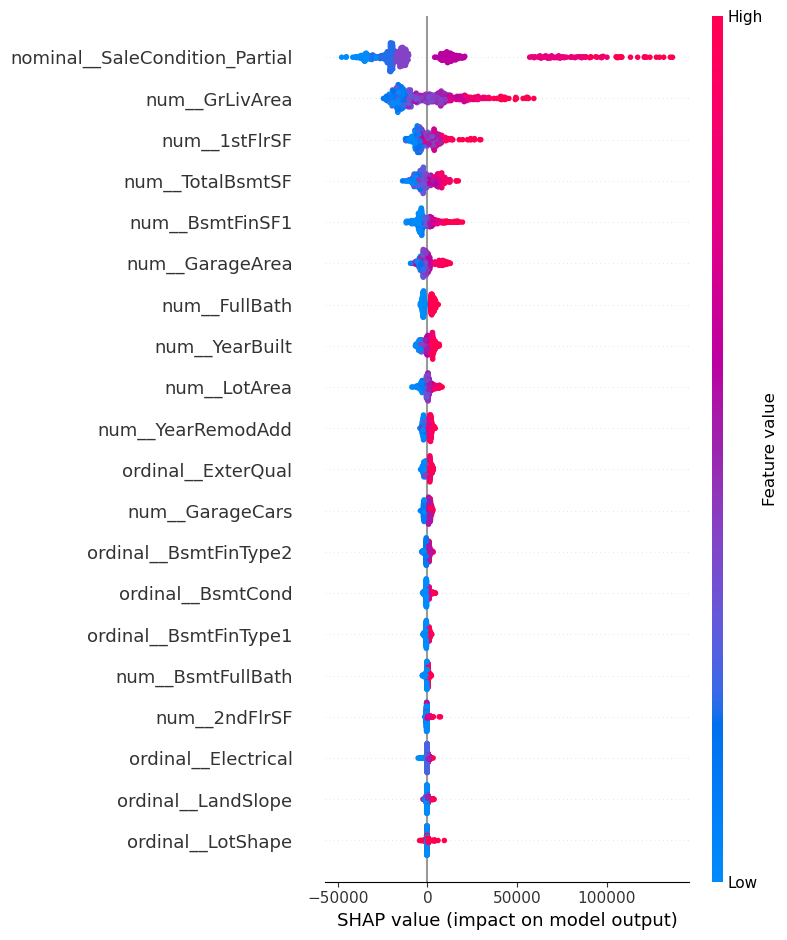

In [646]:
shap.summary_plot(shap_values, X_test_t, feature_names=feature_names)

In [648]:
# X_train['SaleCondition'].value_counts()
X_test['SaleCondition'].value_counts()

SaleCondition
Normal     483
Partial     17
Abnorml     13
Family       2
Alloca       1
Name: count, dtype: int64

In [650]:
# y_train.groupby(X_train['SaleCondition']).mean()
y_test.groupby(X_test['SaleCondition']).mean()

SaleCondition
Abnorml    133576.076923
Alloca     154204.000000
Family     148400.000000
Normal     177545.598344
Partial    311353.705882
Name: SalePrice, dtype: float64

### ChatGPT:

In [652]:
# Get feature names from the fitted preprocessor
feature_names = fitted_pre.get_feature_names_out()
print(f"Total features after transformation: {len(feature_names)}")
print("First 10 feature names:", feature_names[:10])

# Check if ordinal__OverallQual is in there
print("Is ordinal__OverallQual in the data?", 'ordinal__OverallQual' in feature_names)

# Convert to DataFrame for easier analysis
X_train_t_df = pd.DataFrame(X_train_t, columns=feature_names)
X_test_t_df = pd.DataFrame(X_test_t, columns=feature_names)

Total features after transformation: 236
First 10 feature names: ['num__GrLivArea' 'num__LotFrontage' 'num__LotArea' 'num__YearBuilt'
 'num__YearRemodAdd' 'num__MasVnrArea' 'num__BsmtFinSF1' 'num__BsmtFinSF2'
 'num__BsmtUnfSF' 'num__TotalBsmtSF']
Is ordinal__OverallQual in the data? True


In [672]:
# Use X_train_t column names instead of explainer.feature_names
print(f"Total features in X_train_t: {X_train_t.shape[1]}")
print(f"Total features in SHAP values: {shap_values.shape[1]}")

# Get mean absolute SHAP values for ALL features
mean_shap_importance = np.mean(np.abs(shap_values), axis=0)
shap_ranking_full = pd.DataFrame({
    'Feature': X_train_t_df.columns,  # Use your data's column names
    'SHAP_Importance': mean_shap_importance
}).sort_values('SHAP_Importance', ascending=False)

print("Full SHAP ranking (top 15):")
print(shap_ranking_full.head(15))

Total features in X_train_t: 236
Total features in SHAP values: 236
Full SHAP ranking (top 15):
                   Feature  SHAP_Importance
215   ordinal__OverallQual     29532.069927
0           num__GrLivArea     14534.543075
10           num__1stFlrSF      5025.699008
9         num__TotalBsmtSF      4837.346312
6          num__BsmtFinSF1      4188.371525
23         num__GarageArea      2940.154110
15           num__FullBath      2744.735016
3           num__YearBuilt      2476.556248
2             num__LotArea      1795.990845
4        num__YearRemodAdd      1675.347762
222  ordinal__BsmtFinType1      1564.399950
22         num__GarageCars      1443.159269
228  ordinal__GarageFinish      1020.576639
225   ordinal__KitchenQual       922.518068
227   ordinal__FireplaceQu       837.895734


In [676]:
# Search for OverallQual in your feature names (using X_train_t columns)
overall_qual_features = [feat for feat in X_train_t_df.columns if 'OverallQual' in feat]
print(f"OverallQual related features: {overall_qual_features}")

# If found, check its SHAP importance
for feat in overall_qual_features:
    if feat in shap_ranking_full['Feature'].values:
        shap_imp = shap_ranking_full[shap_ranking_full['Feature'] == feat]['SHAP_Importance'].iloc[0]
        rank = shap_ranking_full.reset_index(drop=True)[shap_ranking_full['Feature'] == feat].index[0] + 1
        print(f"{feat}: SHAP importance = {shap_imp:.6f}, Rank = {rank}")

OverallQual related features: ['ordinal__OverallQual']
ordinal__OverallQual: SHAP importance = 29532.069927, Rank = 216


/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_85980/2595529519.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rank = shap_ranking_full.reset_index(drop=True)[shap_ranking_full['Feature'] == feat].index[0] + 1


In [686]:
# Investigate SaleCondition_Partial (fixed version)
sale_features = [feat for feat in X_train_t_df.columns if 'SaleCondition' in feat]
print(f"Available SaleCondition features: {sale_features}")

if 'nominal__SaleCondition_Partial' in X_train_t_df.columns:
    feature_idx = list(X_train_t_df.columns).index('nominal__SaleCondition_Partial')
    
    # Get the feature values and SHAP values for this feature
    feature_values = X_train_t_df.iloc[:, feature_idx]  # Use iloc for positional indexing
    feature_shap = shap_values[:, feature_idx]
    
    print("\nSaleCondition_Partial Analysis:")
    print(f"Value distribution:\n{feature_values.value_counts()}")
    print(f"Percentage of 1s: {feature_values.mean()*100:.2f}%")
    print(f"Mean SHAP when feature=0: {feature_shap[feature_values==0].mean():.4f}")
    print(f"Mean SHAP when feature=1: {feature_shap[feature_values==1].mean():.4f}")
    print(f"SHAP difference: {feature_shap[feature_values==1].mean() - feature_shap[feature_values==0].mean():.4f}")
else:
    print("nominal__SaleCondition_Partial not found in columns")

Available SaleCondition features: ['nominal__SaleCondition_Abnorml', 'nominal__SaleCondition_AdjLand', 'nominal__SaleCondition_Alloca', 'nominal__SaleCondition_Family', 'nominal__SaleCondition_Normal', 'nominal__SaleCondition_Partial']

SaleCondition_Partial Analysis:
Value distribution:
nominal__SaleCondition_Partial
0.0    1999
1.0      65
Name: count, dtype: int64
Percentage of 1s: 3.15%


IndexError: boolean index did not match indexed array along dimension 0; dimension is 516 but corresponding boolean dimension is 2064

### From ChatGPT 
The Discrepancy Explained:
- OverallQual is actually #1 in SHAP importance (29532.069927) - it's the most important feature by SHAP values too!
- But it ranks #216 in the SHAP summary plot - this suggests the plot is showing a filtered or limited view

Why SaleCondition_Partial appears at the top of your SHAP plot:
The SHAP summary plot is likely showing features by their visual impact or spread of values, not by total importance. Since SaleCondition_Partial:
- Only affects 3.15% of cases (rare)
- Has a large effect when it occurs
- Creates distinct clustering patterns in the plot

It gets prioritized for visualization even though OverallQual is actually more important overall.

Key Insights:
- Your original assessment was correct - both methods consistently show OverallQual and GrLivArea as the top 2 most important features
- SHAP summary plots can be misleading - they often prioritize features that create visually interesting patterns rather than showing pure importance rankings
- The model is very consistent - all three methods (RF importance on full data, RF importance on train data, and SHAP values) agree on the core important features

Recommendation:
Trust your feature importance rankings from both Random Forest methods. The SHAP summary plot is useful for understanding how features affect predictions (the direction and spread of effects), but for ranking feature importance, stick with the numerical SHAP importance values you just calculated.
The fact that OverallQual consistently ranks #1 across all methods confirms it's genuinely your most predictive feature, which makes intuitive sense for house price prediction.

# Summary

[Contents](#Contents)

### Model scores and train-test gaps:

In [722]:
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _5,0.8966,0.9770,0.9063,0.0708
Model _4,0.8964,0.9756,0.9058,0.0698
Model _3,0.8959,0.9756,0.9057,0.0698
Model _1,0.8958,0.9746,0.9050,0.0696
Model _0,0.8951,0.9836,0.9088,0.0749
Model _2,0.8938,0.9664,0.9025,0.0639


### Best model hyperparameters:

In [704]:
forest_grid_5.best_params_

{'regressor__max_depth': 26,
 'regressor__min_samples_leaf': 2,
 'regressor__min_samples_split': 4,
 'regressor__n_estimators': 750}

### Top 10 feature importances:
on full dataset

In [315]:
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,Importance
ordinal__OverallQual,0.555441
num__GrLivArea,0.141811
num__1stFlrSF,0.058867
num__TotalBsmtSF,0.040480
num__GarageArea,0.024817
num__BsmtFinSF1,0.024397
num__LotArea,0.013672
num__YearBuilt,0.009570
num__2ndFlrSF,0.007602
num__YearRemodAdd,0.007135


### SHAP Analysis:
on train-test split data

In [699]:
# Display with clear labels
print("=" * 70)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 70)
print(f"{'SHAP Importance':<32} {'Random Forest Importance':<35}")
print("-" * 70)

# Display comparison
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    rf_feat = rf_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {rf_feat}")

FEATURE IMPORTANCE COMPARISON
SHAP Importance                  Random Forest Importance           
----------------------------------------------------------------------
 1. ordinal__Overal		 1. ordinal__Overal
 2. num__GrLivArea 		 2. num__GrLivArea
 3. num__1stFlrSF  		 3. num__1stFlrSF
 4. num__TotalBsmtS		 4. num__TotalBsmtS
 5. num__BsmtFinSF1		 5. num__GarageArea
 6. num__GarageArea		 6. num__BsmtFinSF1
 7. num__FullBath  		 7. num__FullBath
 8. num__YearBuilt 		 8. num__LotArea
 9. num__LotArea   		 9. num__YearBuilt
10. num__YearRemodA		10. num__GarageCars


In [782]:
# save data for model comparisons
rf_models = tuning_results_df.copy()
rf_models['algorithm'] = 'RandomForest'
rf_models

,mean-cv on X and y,train score,test score,train-test gap,algorithm
Model _1,0.8958,0.9746,0.9050,0.0696,RandomForest
Model _2,0.8938,0.9664,0.9025,0.0639,RandomForest
Model _3,0.8959,0.9756,0.9057,0.0698,RandomForest
Model _4,0.8964,0.9756,0.9058,0.0698,RandomForest
Model _5,0.8966,0.9770,0.9063,0.0708,RandomForest
Model _0,0.8951,0.9836,0.9088,0.0749,RandomForest


In [784]:
rf_models.index.name = 'model'
rf_models = rf_models.reset_index()

In [786]:
rf_models

,model,mean-cv on X and y,train score,test score,train-test gap,algorithm
0,Model _1,0.8958,0.9746,0.9050,0.0696,RandomForest
1,Model _2,0.8938,0.9664,0.9025,0.0639,RandomForest
2,Model _3,0.8959,0.9756,0.9057,0.0698,RandomForest
3,Model _4,0.8964,0.9756,0.9058,0.0698,RandomForest
4,Model _5,0.8966,0.9770,0.9063,0.0708,RandomForest
5,Model _0,0.8951,0.9836,0.9088,0.0749,RandomForest


In [788]:
rf_models.to_csv('random_forest_models.csv')

# Resources

[Contents](#Contents)

[How Decision Tree Depth Impacts Accuracy](https://www.geeksforgeeks.org/machine-learning/how-decision-tree-depth-impact-on-the-accuracy/)

# Extra

In [ ]:
# visualize the train-test gap
def evaluate_max_depths(depth_range):
    results = []
    
    for max_depth_value in depth_range:
        for name, pipeline in pipelines.items():
            # Create a copy to avoid modifying the original
            temp_pipeline = Pipeline(pipeline.steps)
            temp_pipeline.named_steps['regressor'].set_params(
                max_depth=max_depth_value, 
                random_state=42
            )
            
            temp_pipeline.fit(X_train, y_train)
            train_score = temp_pipeline.score(X_train, y_train)
            test_score = temp_pipeline.score(X_test, y_test)
            
            results.append({
                'model': name,
                'max_depth': max_depth_value,
                'training_score': train_score,
                'testing_score': test_score
            })
    
    return pd.DataFrame(results)

max_depth_df = evaluate_max_depths(range(1, 20))
max_depth_df

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, model_name in enumerate(max_depth_df['model'].unique()):
    model_data = max_depth_df[max_depth_df['model'] == model_name]
    
    axes[i].plot(model_data['max_depth'], model_data['training_score'], 'o-', label='Training')
    axes[i].plot(model_data['max_depth'], model_data['testing_score'], 's-', label='Testing')
    axes[i].set_title(f'{model_name}: Training vs. Testing Scores')
    axes[i].set_xticks(range(0, 21, 2))
    axes[i].set_xlabel('Max. Depth')
    axes[i].set_ylabel('R² Score')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Tuning the random forest model
forest_params_2 = {
    'regressor__max_depth': [15, 20, 25],
    'regressor__min_samples_split': [2, 5, 8],
    # 'regressor__min_samples_leaf': [15, 20, 25],
    'regressor__ccp_alpha': [0.0, 0.01, 0.05, 0.1] 
}

forest_grid_2 = GridSearchCV(
    pipelines['forest'], 
    forest_params_2, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)
forest_grid_2.fit(X, y)
forest_best_model_2 = forest_grid_2.best_estimator_
print(f"Best RandomForest model parameters: {forest_grid_2.best_params_}")
print(f"Best RandomForest mean cv score: {forest_grid_2.best_score_:.4f}")

# check for overfitting
forest_grid_1.fit(X_train, y_train)
best_train_model = forest_grid_1.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

forest_grid_2.fit(X, y)
forest_best_model_2 = forest_grid_2.best_estimator_
print(f"Best RandomForest model parameters: {forest_grid_2.best_params_}")
print(f"Best RandomForest mean cv score: {forest_grid_2.best_score_:.4f}")

# check for overfitting
forest_grid_2.fit(X_train, y_train)
best_train_model2 = forest_grid_2.best_estimator_
train_score = best_train_model2.score(X_train, y_train)
test_score = best_train_model2.score(X_test, y_test)
diff = train_score - test_score
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# RFECV 
recursive feature elimination

Does not work as expected on RandomForest because of the encoding... Returns subcategories of features, not the entire features themselves... ?

In [193]:
# from sklearn.feature_selection import RFECV

# # Your existing transformers
# numerical_transformer = Pipeline(steps=[
#     ('num', 'passthrough')
# ])

# nominal_transformer = Pipeline(steps=[
#     ('nominal', OneHotEncoder(handle_unknown='ignore'))
# ])

# ord_categories = [ordinal_order[feature] for feature in ordinal_features_list]
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=ord_categories))
# ])

# # Set up preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features_list),
#         ('nominal', nominal_transformer, nominal_features_list),
#         ('ordinal', ordinal_transformer, ordinal_features_list)
# ])

# # Create the base model for RFECV
# rfe_model = ensemble.RandomForestRegressor(
#     max_depth = 26, 
#     min_samples_leaf = 2,
#     min_samples_split = 4, 
#     n_estimators = 700,
#     random_state=42
# )

# # Create RFECV selector
# rfe_selector = RFECV(
#     estimator=rfe_model, 
#     step=1, 
#     cv=5,
#     scoring='r2', 
#     min_features_to_select=1
# )

# # Update pipeline with RFECV
# pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('feature_selection', rfe_selector),
#         ('regressor', ensemble.RandomForestRegressor(random_state=42,
#                                                      max_depth = 26, 
#                                                      min_samples_leaf = 2,
#                                                      min_samples_split = 4, 
#                                                      n_estimators = 700))
# ])

In [197]:
# # Fit the pipeline
# pipeline.fit(X, y)

In [ ]:
# # Make predictions
# predictions = pipelines['forest_rfe'].predict(X_test)

In [ ]:
# # Access the selected features
# selected_mask = pipelines['forest_rfe'].named_steps['feature_selection'].support_
# feature_names = pipelines['forest_rfe'].named_steps['preprocessor'].get_feature_names_out()
# selected_features = feature_names[selected_mask]
# print(f"Selected features: {selected_features}")